<a href="https://colab.research.google.com/github/spyrosmi/example-of-readme.md/blob/main/macrophages_scvi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install -U cellxgene-census # install cellxgene-census to gain access to the datasets

In [ ]:
!pip install anndata==0.9.2
!pip install scvi-tools
!pip install scanpy
import scvi
!pip install scikit-misc
import skmisc
import locale
locale.getpreferredencoding=lambda: "UTF-8"
!pip install leidenalg
import leidenalg
import scanpy as sc
import numpy as np

In [ ]:
import cellxgene_census # download the datasets

with cellxgene_census.open_soma() as census:
     adata = cellxgene_census.get_anndata(
        census = census,
        organism = "Mus musculus",
        obs_value_filter = "is_primary_data == True and cell_type in ['macrophage', 'central nervous system macrophage', 'alveolar macrophage', 'lung macrophage', 'macrophage dendritic cell progenitor', 'tissue-resident macrophage']"
     )


In [7]:
adata=adata[adata.obs["assay"].str.contains("10x")] # filter the datasets so that only dat agenerated via 10X protocols are included

In [8]:
adata.var.set_index("feature_name", inplace=True) # set gene names as index of adata.var

In [11]:
adata

View of AnnData object with n_obs × n_vars = 32803 × 52417
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars'
    var: 'soma_joinid', 'feature_id', 'feature_length', 'nnz', 'n_measured_obs'

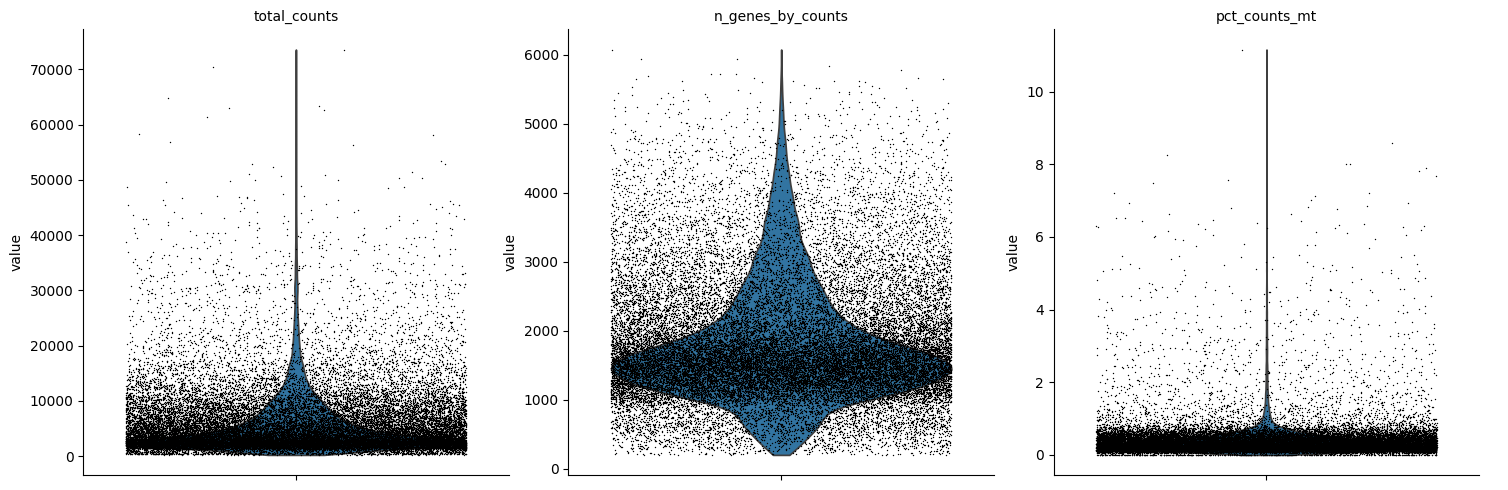

In [15]:
adata.var["mt"]=adata.var_names.str.startswith("Mt")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=False, inplace=True, log1p=False)
sc.pl.violin(adata, ["total_counts", "n_genes_by_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True) #detect mitochondrial genes and caclulcate pct_mt, total_counts and n_genes_by_counts for the cells

In [ ]:
sc.pp.filter_genes(adata, min_cells=10) # filter out low quality genes
sc.pp.filter_cells(adata, min_genes=200) # filter out low quality cells

In [ ]:
import numpy as np

In [16]:
upper_lim=np.quantile(adata.obs.n_genes_by_counts, .99)
upper_lim # filter out outliers

4604.0999999999985

In [17]:
adata=adata[adata.obs.n_genes_by_counts < upper_lim]
adata=adata[adata.obs.pct_counts_mt < 2] #define threshold for pct_counts_mt
adata

View of AnnData object with n_obs × n_vars = 31876 × 19485
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'soma_joinid', 'feature_id', 'feature_length', 'nnz', 'n_measured_obs', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [19]:
adata.layers["counts"]=adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw=adata # freeze data before selecting highly variable genes

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


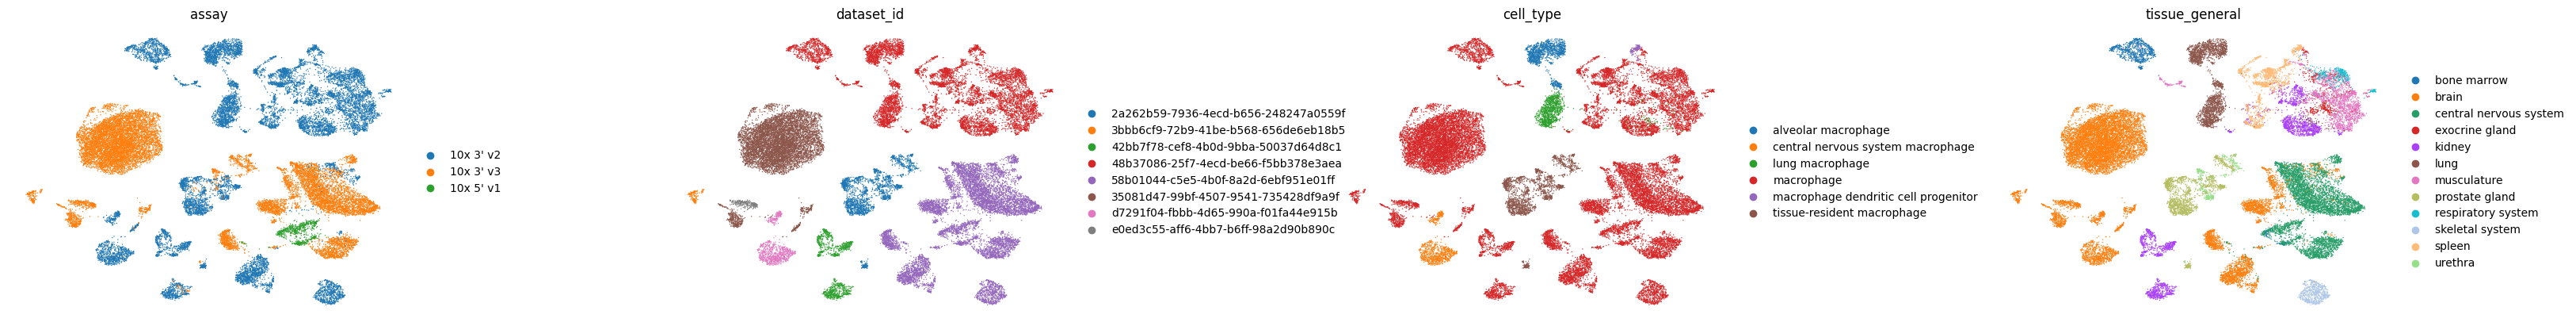

In [20]:
sc.pp.highly_variable_genes(adata, n_top_genes=10000)
data=adata[:,adata.var["highly_variable"]].copy()
sc.tl.pca(data, svd_solver="arpack")
sc.pp.neighbors(data, n_pcs=30)
sc.tl.umap(data)
sc.tl.leiden(data, resolution=1.0, key_added="no_scvi")
sc.pl.umap(data, color=["assay", "dataset_id", "cell_type", "tissue_general"], frameon=False, wspace=0.5) # validate that there are batch effects in the data. The data are clustered primarily by dataset_id.

In [21]:
adata.obs["batch"]=adata.obs["dataset_id"].astype("str") + adata.obs["assay_ontology_term_id"].astype("str") + adata.obs["donor_id"].astype("str") + adata.obs["suspension_type"].astype("str") # create the batch_key for scVI

In [24]:
m=adata.obs["batch"].value_counts()

In [25]:
valid=m[m>100].index

In [26]:
adata.obs.batch.value_counts() # some combinatios of batch_key are repeated only once. Therefore, exclude combinations repeated less than 100 times to allow scVI perform properly

58b01044-c5e5-4b0f-8a2d-6ebf951e01ffEFO:0009922Control Whole Brain + dura, Ctrl_PBS_12h_K72cell    1674
48b37086-25f7-4ecd-be66-f5bb378e3aeaEFO:000989930-M-2cell                                          1650
58b01044-c5e5-4b0f-8a2d-6ebf951e01ffEFO:0009922Meninges Old 2cell                                  1404
58b01044-c5e5-4b0f-8a2d-6ebf951e01ffEFO:000989916 months WT Whole Braincell                        1195
58b01044-c5e5-4b0f-8a2d-6ebf951e01ffEFO:0009922Meninges Old 1cell                                  1188
                                                                                                   ... 
d7291f04-fbbb-4d65-990a-f01fa44e915bEFO:0009899410109cell                                             1
d7291f04-fbbb-4d65-990a-f01fa44e915bEFO:0009899414899cell                                             1
d7291f04-fbbb-4d65-990a-f01fa44e915bEFO:0009899398348cell                                             1
d7291f04-fbbb-4d65-990a-f01fa44e915bEFO:0009899392473cell       

In [27]:
adata=adata[adata.obs.batch.isin(valid)]

In [ ]:
sc.pp.highly_variable_genes(adata, n_top_genes=10000, flavor="seurat_v3", layer="counts", batch_key="batch", subset=True, span=1) # select highly variable genes fro the raw data. scVI requires raw data

In [30]:
adata=adata.copy()
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch", )
model=scvi.model.SCVI(adata, n_layers=5, n_latent=30, n_hidden=128, gene_likelihood="nb", dispersion="gene")
model.train() # train scVI model to remove technical noise from data

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 273/273: 100%|██████████| 273/273 [13:29<00:00,  2.94s/it, v_num=1, train_loss_step=3.07e+3, train_loss_epoch=3e+3]

INFO: `Trainer.fit` stopped: `max_epochs=273` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=273` reached.


Epoch 273/273: 100%|██████████| 273/273 [13:29<00:00,  2.97s/it, v_num=1, train_loss_step=3.07e+3, train_loss_epoch=3e+3]


In [31]:
latent=model.get_latent_representation()
adata.obsm["X_scVI1"]=latent # extract latent representation

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


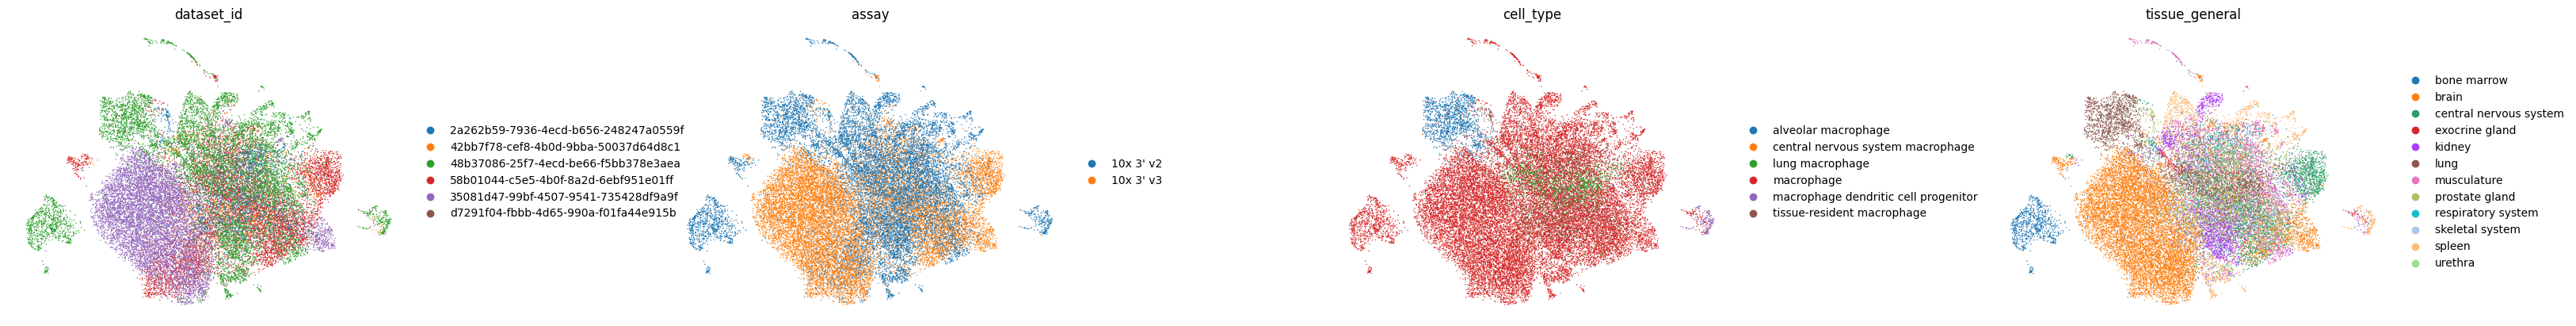

In [32]:
sc.pp.neighbors(adata, use_rep="X_scVI1")
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="scvi", resolution=0.5)
sc.pl.umap(adata, color=["dataset_id", "assay", "cell_type", "tissue_general"], wspace=0.5, frameon=False) #visualize scVI results

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


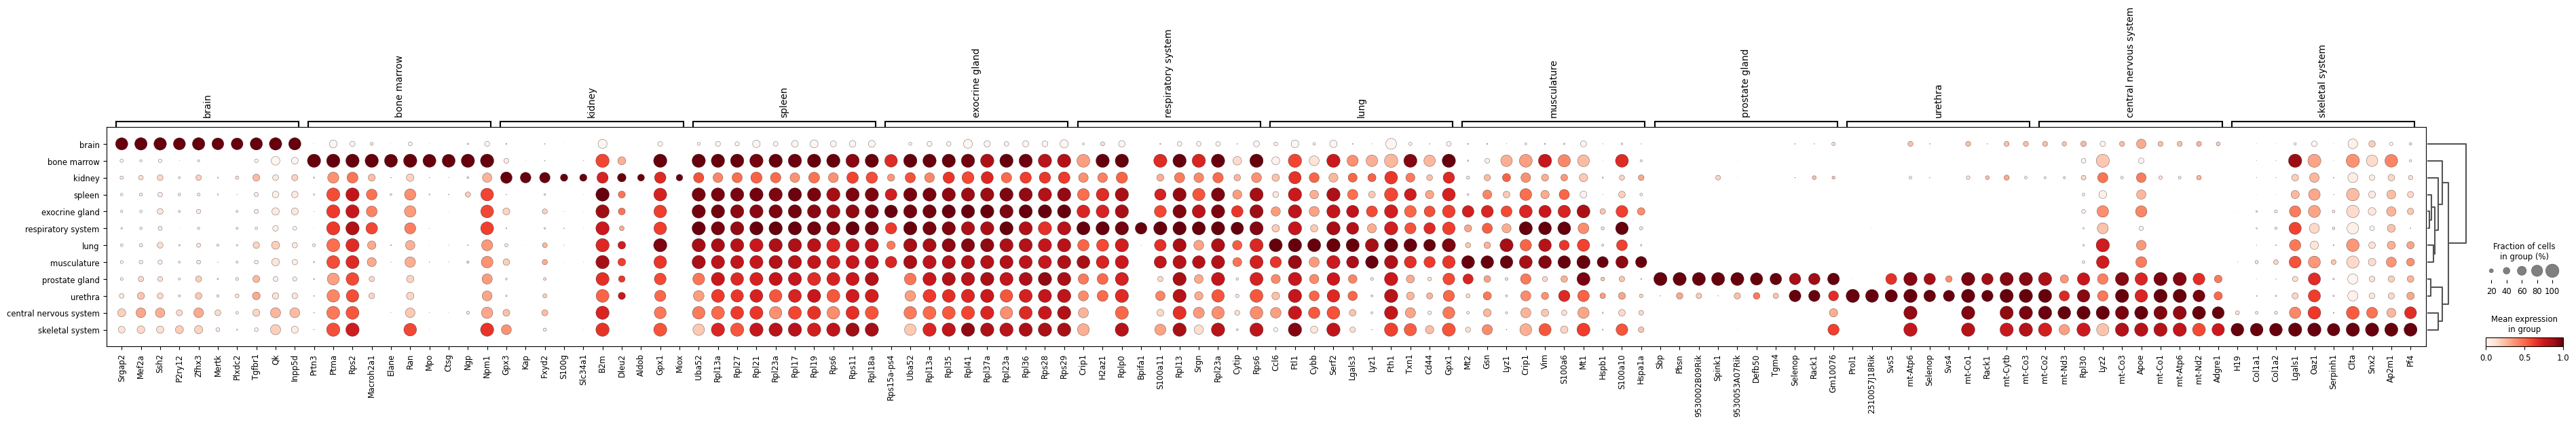

In [34]:
sc.tl.rank_genes_groups(adata, method="wilcoxon", key_added="genes", groupby="tissue_general",)
sc.pl.rank_genes_groups_dotplot(adata, key="genes", n_genes=10, groupby="tissue_general", standard_scale="var") # visualize 5 highly variable genes per tissue. In case ribosomal and mtochondrial genes are still present, adjustment can be bone to the data by defining new thresholds

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


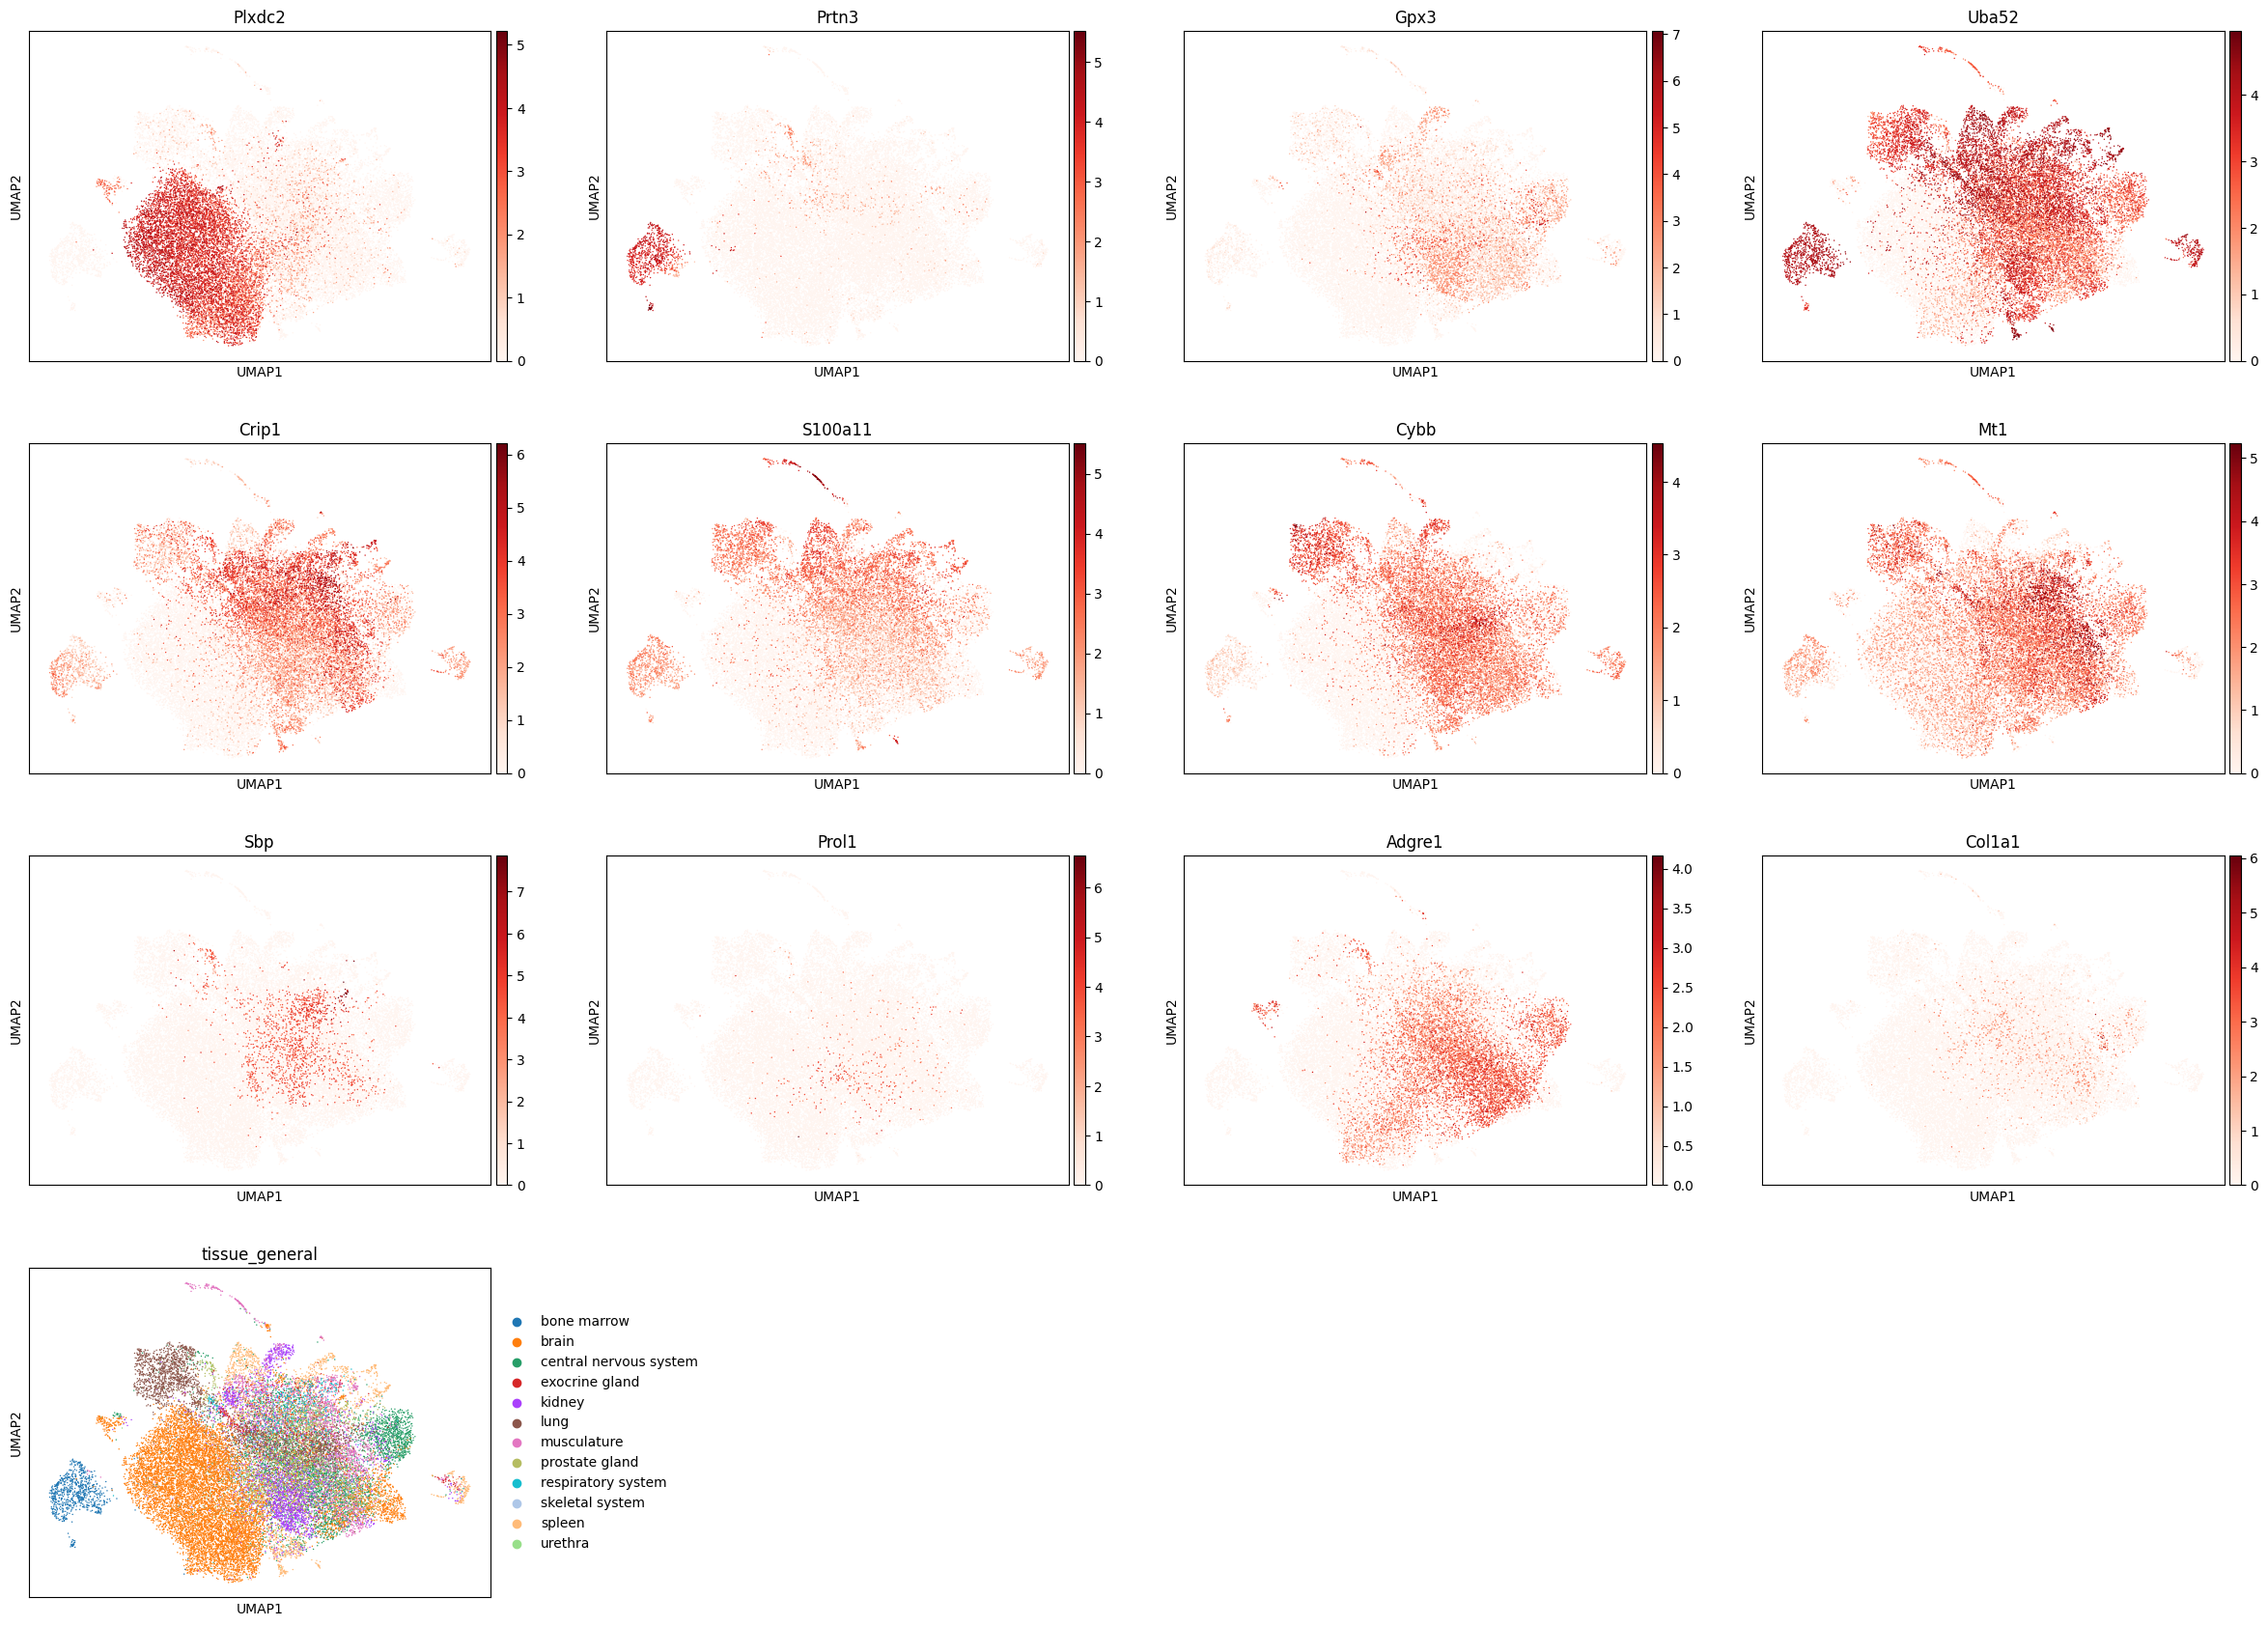

In [36]:
sc.pl.umap(adata, color=["Plxdc2", "Prtn3", "Gpx3", "Uba52", "Crip1", "S100a11", "Cybb", "Mt1", "Sbp", "Prol1", "Adgre1", "Col1a1", "tissue_general"], cmap="Reds")